In [1]:
from google.colab import files
files.upload()

Saving kaggle (2).json to kaggle (2).json


{'kaggle (2).json': b'{"username":"samahassan13","key":"d3b8520d9c664ac21efe6078e3a163db"}'}

In [13]:
import os
os.makedirs('/root/.kaggle', exist_ok=True)

!mv /content/kaggle.json /root/.kaggle/kaggle.json

# Give permissions
!chmod 600 /root/.kaggle/kaggle.json

In [3]:
import kaggle
kaggle.api.authenticate()
kaggle.api.dataset_download_files(
      'gannayasser/arabic-alphabets-sign-language-dataset-arasl',
      path='.',
      unzip=True
  )

Dataset URL: https://www.kaggle.com/datasets/gannayasser/arabic-alphabets-sign-language-dataset-arasl


In [4]:
import os
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='librosa')

import numpy as np
import seaborn as sns
import librosa
import shutil
from io import BytesIO
from PIL import Image, ImageOps, ImageFile
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from pathlib import Path
import pickle as plk

In [5]:
ROOT = '/content/ArASL_Database_54K_Final/ArASL_Database_54K_Final'
IMG_SIZE = (224, 224)
BATCH_SIZE = 32


train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    ROOT,
    labels='inferred',
    label_mode='categorical',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.2 + 0.1,
    subset='training',
    seed=42
)


NUM_CLASSES = len(train_ds_raw.class_names)


val_test_ds_raw = tf.keras.utils.image_dataset_from_directory(
    ROOT,
    labels='inferred',
    label_mode='categorical',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.3,
    subset='validation',
    seed=42
)

val_batches = int(len(val_test_ds_raw) * 0.5)
val_ds_raw = val_test_ds_raw.take(val_batches)
test_ds_raw = val_test_ds_raw.skip(val_batches)

# Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds_raw.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds_raw.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds_raw.prefetch(buffer_size=AUTOTUNE)


Found 54049 files belonging to 32 classes.
Using 37835 files for training.
Found 54049 files belonging to 32 classes.
Using 16214 files for validation.


In [6]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,090,563 (15.60 MB)

 Trainable params: 40,992 (160.12 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [7]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [8]:
EPOCHS = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/10
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 97s 60ms/step - accuracy: 0.6172 - loss: 1.5347 - val_accuracy: 0.9146 - val_loss: 0.4082
Epoch 2/10
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 48s 41ms/step - accuracy: 0.8946 - loss: 0.4323 - val_accuracy: 0.9482 - val_loss: 0.2585
Epoch 3/10
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 49s 41ms/step - accuracy: 0.9238 - loss: 0.3115 - val_accuracy: 0.9618 - val_loss: 0.1905
Epoch 4/10
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 49s 41ms/step - accuracy: 0.9341 - loss: 0.2575 - val_accuracy: 0.9675 - val_loss: 0.1578
Epoch 5/10
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 81s 41ms/step - accuracy: 0.9430 - loss: 0.2210 - val_accuracy: 0.9708 - val_loss: 0.1374
Epoch 6/10
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 82s 41ms/step - accuracy: 0.9443 - loss: 0.2019 - val_accuracy: 0.9721 - val_loss: 0.1238
Epoch 7/10
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 84s 43ms/step - accuracy: 0.9496 - loss: 0.1870 - val_accuracy: 0.9742 - val_loss: 0.1137
Epoch 8/10
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 80s 41ms/step - accuracy: 0.9494 -

In [9]:
base_model.trainable = True
model.compile(optimizer=Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


history_ft = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)


Epoch 1/5
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 267s 165ms/step - accuracy: 0.5009 - loss: 1.9857 - val_accuracy: 0.9002 - val_loss: 5.2685
Epoch 2/5
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 153s 130ms/step - accuracy: 0.8361 - loss: 0.5029 - val_accuracy: 0.9570 - val_loss: 0.8529
Epoch 3/5
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 155s 131ms/step - accuracy: 0.9123 - loss: 0.2734 - val_accuracy: 0.9713 - val_loss: 0.1894
Epoch 4/5
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 156s 132ms/step - accuracy: 0.9387 - loss: 0.1875 - val_accuracy: 0.9773 - val_loss: 0.1452
Epoch 5/5
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 199s 129ms/step - accuracy: 0.9572 - loss: 0.1302 - val_accuracy: 0.9828 - val_loss: 0.1117


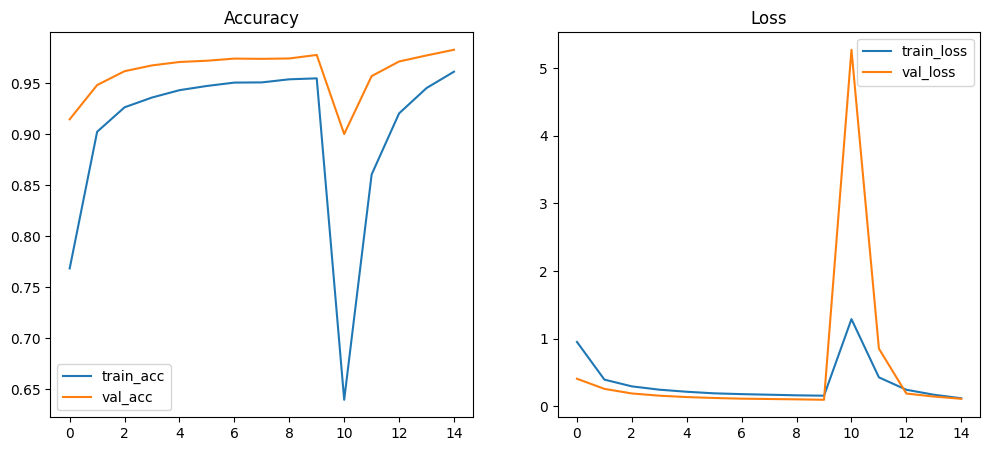

In [10]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'] + history_ft.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'] + history_ft.history['val_accuracy'], label='val_acc')
plt.title('Accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'] + history_ft.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'] + history_ft.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.legend()

plt.show()

In [11]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc*100:.2f}%")

254/254 ━━━━━━━━━━━━━━━━━━━━ 23s 72ms/step - accuracy: 0.9839 - loss: 0.0611
Test Accuracy: 98.47%


In [4]:
save_path = "arsl_efficientnetb0_model.h5"
model.save(save_path)
print("Saved to", save_path)


NameError: name 'model' is not defined